In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


(300, 300, 3)


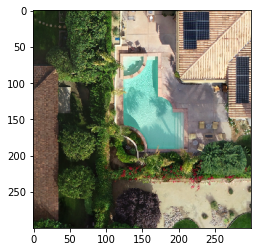

In [0]:
path0 = '/content/gdrive/My Drive/project_files/'
path = path0+'image-chips/'
image = cv2.imread(path+'1d4fbe33f3_F1BE1D4184INSPIRE-000000.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert the image from BGR to RGB
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert the image from BGR to GRAY

print(image_rgb.shape)
plt.imshow(image_rgb)

(300, 300, 3)
[[4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 [4 4 4 ... 0 0 0]
 ...
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]
 [2 2 2 ... 4 4 4]]
[0 1 2 3 4]


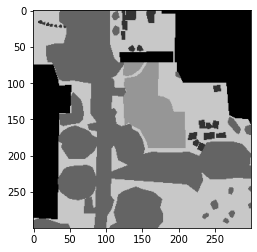

In [0]:
path = path0+'label-chips/'
GT = plt.imread(path+'1d4fbe33f3_F1BE1D4184INSPIRE-000000.png')
print(GT.shape)
image_grount_truth = GT[:,:,0]
GT = np.round(GT*1000)/4
GT = GT.astype('int')
print(GT[:,:,2])
unique_elements = np.unique(GT)
print(unique_elements)

# (075, 025, 230) : BUILDING
# (180, 030, 145) : CLUTTER
# (075, 180, 060) : VEGETATION
# (048, 130, 245) : WATER
# (255, 255, 255) : GROUND
# (200, 130, 000) : CAR
# (255, 000, 255) : IGNORE

plt.imshow(GT*50, cmap='gray')

In [0]:
# import the necessary packages
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow

img = image.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 3)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.4*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

# show segmentation
image_segmented = markers.copy()
image_segmented = image_segmented.reshape(img.shape[0], image.shape[1])

[-1  1  2  3  4  5  6  7]


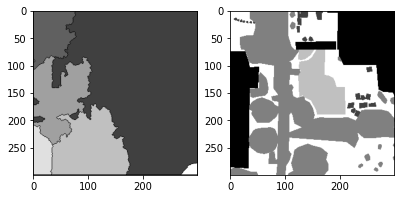

In [0]:
print(np.unique(image_segmented))

fig1 = plt.figure(figsize=(10,20))  # create a figure object
ax = fig1.add_subplot(1, 3, 1)  # create an axes object in the figure
ax.imshow(image_segmented , cmap='gray')
ax = fig1.add_subplot(1, 3, 2)  # create an axes object in the figure
ax.imshow(GT[:,:,0]*40  , cmap='gray')
# BUILDING:0, CLUTTER:1 , VEGETATION:2, WATER:3, GROUND:4, CAR:5, IGNORE:6

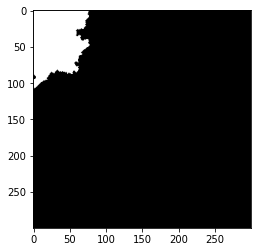

In [0]:
plt.imshow(image_segmented == 2, cmap='gray')

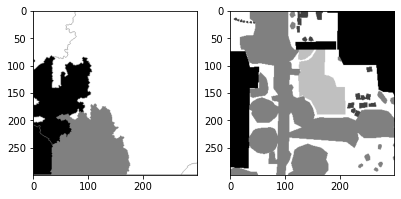

In [0]:
image_segmented_new = np.zeros(image_segmented.shape)
idx = image_segmented==-1
image_segmented_new[idx] = 2 # vegetation
idx = image_segmented==1
image_segmented_new[idx] = 4 # ground
idx = image_segmented==2
image_segmented_new[idx] = 4 # ground
idx = image_segmented==3
image_segmented_new[idx] = 0 # building
idx = image_segmented==4
image_segmented_new[idx] = 0 # building
idx = image_segmented==5
image_segmented_new[idx] = 2 # vegetation
idx = image_segmented==6
image_segmented_new[idx] = 0 # building
idx = image_segmented==7
image_segmented_new[idx] = 4 # ground

image_segmented_new = image_segmented_new.astype(int)
fig1 = plt.figure(figsize=(10,20))  # create a figure object
ax = fig1.add_subplot(1, 3, 1)  # create an axes object in the figure
ax.imshow(image_segmented_new, cmap='gray')
ax = fig1.add_subplot(1, 3, 2)  # create an axes object in the figure
ax.imshow(GT[:,:,0]*40  , cmap='gray')
# BUILDING:0, CLUTTER:1 , VEGETATION:2, WATER:3, GROUND:4, CAR:5, IGNORE:6

In [0]:
from skimage.color import rgb2gray
from skimage.metrics import (adapted_rand_error,variation_of_information)

gray_original = rgb2gray(image)

# compute metrics
Grount_truth_matrix = GT[:,:,0]
# print(Grount_truth_matrix.shape)
# print(gray_original.shape)
# print(Grount_truth_matrix)
# print(image_segmented_new)

error, precision, recall = adapted_rand_error(Grount_truth_matrix, image_segmented_new)
print("\nWatershed:")
print("Error: " , error*100)
print("precision: " , precision*100)
print("recall: " , recall*100)
splits, merges = variation_of_information(Grount_truth_matrix, image_segmented_new)


from sklearn.metrics import accuracy_score
ACC = accuracy_score(Grount_truth_matrix.reshape(Grount_truth_matrix.shape[0]*Grount_truth_matrix.shape[1]), 
                     image_segmented_new.reshape(image_segmented_new.shape[0]*image_segmented_new.shape[1]))
print("ACC: " , ACC*100)


Watershed:
Error:  55.091348247464445
precision:  53.15309912416936
recall:  38.878329092490546
ACC:  43.315555555555555
